## Setting up our Python environment

In addition to the normal inputs, we'll grab Bessel functions from `scipy.special`. There are different conventions, but we'll mostly be using the $J_n$'s

In [1]:
import numpy as np, scipy as sp, matplotlib.pyplot as plt, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed
from matplotlib import cm
from numpy import sin, cos, arctan, arctan2, array, sqrt, linspace, meshgrid, pi
#%matplotlib inline
import scipy.special
from scipy.special import j0,j1,jn,y0,y1,yn, jn_zeros

# Let's re-familiarize ourselves with Bessel functions

### J's

Make a little widget to plot as many Bessel functions of the first kind as we want:

In [4]:
x = np.linspace(0,20,10000)
fig = plt.figure()
def plotfirstkind(N=0):
    for n in range(N):
        plt.plot(x,jn(n,x),label="$J_{n}(x)$".format(n=n))
    if N>0: 
        plt.legend()
    plt.show()
_=interact(plotfirstkind,N=(0,10));

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=0, description='N', max=10), Output()), _dom_classes=('widget-interact',…

### Y's

Make a little widget to plot as many Bessel functions of the second kind as we want

In [5]:
x = np.linspace(0,20,10000)
def plotsecondkind(N=0):
    for n in range(N):
        plt.plot(x,yn(n,x),label="$Y_{n}(x)$".format(n=n))
    if N>0: plt.legend()
    plt.show()
interact(plotsecondkind,N=(0,10))

interactive(children=(IntSlider(value=0, description='N', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.plotsecondkind(N=0)>

Oops! How many bessel functions of the second kind to plot?

In [6]:
def plotsecondkind(N=0,x0=0):
    x = np.linspace(x0,20,10000)
    for n in range(N):
        plt.plot(x,yn(n,x),label="$Y_{n}(x)$".format(n=n))
    if N>0: plt.legend()
    plt.show()
interact(plotsecondkind,N=(0,10),x0=(0,1,0.1))

interactive(children=(IntSlider(value=0, description='N', max=10), FloatSlider(value=0.0, description='x0', ma…

<function __main__.plotsecondkind(N=0, x0=0)>

Or maybe this

In [7]:
def plotsecondkind(N=0,ymax=2,ymin=-2):
    x = np.linspace(0,20,10000)
    for n in range(N):
        plt.plot(x,yn(n,x),label="$Y_{n}(x)$".format(n=n))
    plt.ylim([ymin,ymax])
    if N>0: plt.legend()
    plt.show()
interact(plotsecondkind,N=(0,10),x0=(0,1,0.1))

interactive(children=(IntSlider(value=0, description='N', max=10), IntSlider(value=2, description='ymax', max=…

<function __main__.plotsecondkind(N=0, ymax=2, ymin=-2)>

### Great. Now a series.

This one happens to be designed to make a square wave up to the first zero.

Here's a significant difference with Fourier series: look at what happens after the first zero.

In [8]:
def k(m,n):
    # jn_zeros(n, nt): Compute nt zeros of the Bessel function Jn(x).
    return jn_zeros(n,m)[m-1] # m is 0-indexed here

def km0(m):
    #jn_zeros(n, nt): Compute nt zeros of the Bessel function Jn(x).
    # I.e. this returns an array, and we take the last element.
    return jn_zeros(0,m)[-1]

def plotseries(N=0,xmax=1):
    x = np.linspace(0,xmax,xmax*1000)
    plt.clf()
    y = np.zeros_like(x)
    for m in range(1,N+1):
        km = km0(m)
        cm = 200/(km * jn(1,km))
        #print "cm",cm
        this_term = cm*jn(0,km*x)
        plt.plot(x,this_term,label="$Term %s$"%m)
        y = y + this_term
    plt.plot(x,y,'k',linewidth=3,label='sum')
    plt.legend()
    plt.show()
_ = interact(plotseries,N=(1,15),xmax=(1,20,5))

interactive(children=(IntSlider(value=1, description='N', max=15, min=1), IntSlider(value=1, description='xmax…

# Now on to the steady state temperature in a cylinder

Assuming you solved this in class, you know we're looking for things like

$$
u = \left\{\begin{matrix}
J_n(kr/a)\sin n\theta e^{-kz/a}\\ 
J_n(kr/a)\cos n\theta e^{-kz/a}
\end{matrix}\right.
$$

where we need symmetry in $\theta$, choosing

$$
u = \sum_{m=1}^\infty c_m J_0(k_mr/a)e^{-k_mz/a}
$$

with the $c_m$'s given as above

$$
c_m = \frac{200}{k_mJ_1(k_m)}
$$

So, let's plot that. Remember, we want the above function over the drum head, and zero elsewhere.

First, let's all read through Boas together

... reading ...

Now let's plot some things!

First thought: plot the temperature as a surface, with height = Temperature.

In [9]:
from ipywidgets import interact, interactive, fixed

In [10]:
def plot_surface_interpolate(f,urange=2,z=0.1,elev=None,azim=None,zmax=150):
    u1 = np.linspace(-urange,urange,100)
    u2 = np.linspace(-urange,urange,100)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    U1, U2 = np.meshgrid(u1, u2)
    X,Y,Z = f(U1,U2)
    U3 = np.zeros_like(Z)
    A = U1
    B = U2
    C = U3+z
    surf2 = ax.plot_surface(U1, U2, np.zeros_like(C), color='grey', alpha=0.5)
    surf = ax.plot_surface(X,Y,Z,alpha=0.9,color='blue')
    surf3 = ax.plot_surface(A,B,C,color='green',zorder=-2,alpha=0.1)
    ax.view_init(elev=elev,azim=azim)
    ax.set_zlim([0,zmax])
    plt.show()


In [11]:
interp_step = 0.1
degree_step=15

In [12]:
def plot_this(azim=30,elev=30,z=0,N=1,zmax=150):
    def f(X,Y,z=z,N=N):
        R = np.sqrt(X**2 + Y**2)
        Z = np.zeros_like(R)
        for m in range(1,N+1):
            km = km0(m)
            cm = 200/(km * jn(1,km))
            this_term = cm*jn(0,km*R)*np.exp(-km*z)
            Z = Z + this_term
        Z[R>1] = 0
        return X,Y,z+Z
    plot_surface_interpolate(f,z=z,azim=azim,elev=elev,zmax=zmax)
    print('N=',N)
interact(plot_this,z=(0,10,0.1),N=(1,20,1),
         azim=(0,360,degree_step),elev=(0,360,degree_step),
         zmax=(0,150,10)
        )

interactive(children=(IntSlider(value=30, description='azim', max=360, step=15), IntSlider(value=30, descripti…

<function __main__.plot_this(azim=30, elev=30, z=0, N=1, zmax=150)>

Do we want to "fix" outside R=1?
Do we want to show far from R=1?

So that's interesting, but kind of hard to visualize. Let's plot Z on the y axis, and R on the x-axis.

In [13]:
def plot_temp(r_range=2,z_range=2,N=1):
    plt.clf()
    r = np.linspace(0,r_range,100)
    z = np.linspace(0,z_range,100)
    fig = plt.figure()
    R, Z = np.meshgrid(r, z)
    def f(R,Z,N=N):
        T = np.zeros_like(R)
        for m in range(1,N+1):
            km = km0(m)
            cm = 200/(km * jn(1,km))
            this_term = cm*jn(0,km*R)*np.exp(-km*Z)
            T = T + this_term
        return T
    T = f(R,Z,N)
    #plt.imshow(T,cmap=plt.get_cmap('inferno'),origin='lower')
    plt.pcolormesh(R,Z,T,cmap=plt.get_cmap('inferno'))
    plt.colorbar()
    plt.show()
interact(plot_temp,N=(1,20,1),r_range=(1,5,1),z_range=(.1,10,.1))

interactive(children=(IntSlider(value=2, description='r_range', max=5, min=1), FloatSlider(value=2.0, descript…

<function __main__.plot_temp(r_range=2, z_range=2, N=1)>

/var/folders/4w/ssz2zjl56pxgf3w8b2b78c2c0000gr/T/ipykernel_20666/3640184437.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(R,Z,T,cmap=plt.get_cmap('inferno'))


<Figure size 432x288 with 0 Axes>

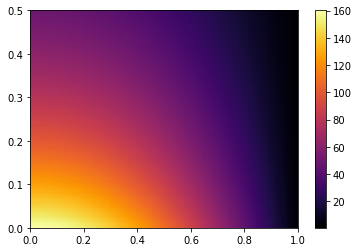

In [14]:
plot_temp(1.0,0.5,1)

/var/folders/4w/ssz2zjl56pxgf3w8b2b78c2c0000gr/T/ipykernel_20666/3640184437.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(R,Z,T,cmap=plt.get_cmap('inferno'))


<Figure size 432x288 with 0 Axes>

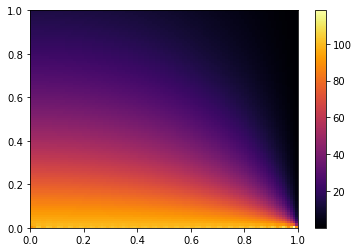

In [15]:
plot_temp(1.0,1,50)

In [16]:
a = 1
r = np.linspace(0,a,100)
z = np.linspace(0,4*a,400)
R,Z = np.meshgrid(r,z)

def plotcyl(N=0):
    plt.clf()
    y = np.zeros_like(x)
    for m in range(1,N+1):
        km = km0(m)
        cm = 200/(km * jn(1,km))
        #print "cm",cm
        this_term = cm*jn(0,km*x)
        plt.plot(x,this_term,label="$Term %s$"%m)
        y = y + this_term
    plt.plot(x,y,'k',linewidth=3,label='sum')
    plt.legend()
    plt.show()
_ = interact(plotseries,N=(1,15))

interactive(children=(IntSlider(value=1, description='N', max=15, min=1), IntSlider(value=1, description='xmax…

/var/folders/4w/ssz2zjl56pxgf3w8b2b78c2c0000gr/T/ipykernel_20666/4191142078.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
No handles with labels found to put in legend.


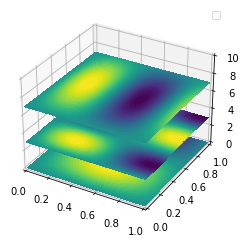

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')

x = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, x)
Z = np.sin(X)*np.sin(Y)

levels = np.linspace(-1, 1, 40)

ax.contourf(X, Y, .1*np.sin(3*X)*np.sin(5*Y), zdir='z', levels=.1*levels)
ax.contourf(X, Y, 3+.1*np.sin(5*X)*np.sin(8*Y), zdir='z', levels=3+.1*levels)
ax.contourf(X, Y, 7+.1*np.sin(7*X)*np.sin(3*Y), zdir='z', levels=7+.1*levels)

ax.legend()
ax.set_xlim3d(0, 1)
ax.set_ylim3d(0, 1)
ax.set_zlim3d(0, 10)

plt.show()


In [20]:
from mpl_toolkits.mplot3d import proj3d

def make_get_proj(self, rx, ry, rz):
    '''
    Return a variation on :func:`~mpl_toolkit.mplot2d.axes3d.Axes3D.getproj` that
    makes the box aspect ratio equal to *rx:ry:rz*, using an axes object *self*.
    '''

    rm = max(rx, ry, rz)
    kx = rm / rx; ky = rm / ry; kz = rm / rz;

    # Copied directly from mpl_toolkit/mplot3d/axes3d.py. New or modified lines are
    # marked by ##
    def get_proj():
        relev, razim = np.pi * self.elev/180, np.pi * self.azim/180

        xmin, xmax = self.get_xlim3d()
        ymin, ymax = self.get_ylim3d()
        zmin, zmax = self.get_zlim3d()

        # transform to uniform world coordinates 0-1.0,0-1.0,0-1.0
        worldM = proj3d.world_transformation(xmin, xmax,
                                             ymin, ymax,
                                             zmin, zmax)

        # adjust the aspect ratio                          ##
        aspectM = proj3d.world_transformation(-kx + 1, kx, ##
                                              -ky + 1, ky, ##
                                              -kz + 1, kz) ##

        # look into the middle of the new coordinates
        R = np.array([0.5, 0.5, 0.5])

        xp = R[0] + np.cos(razim) * np.cos(relev) * self.dist
        yp = R[1] + np.sin(razim) * np.cos(relev) * self.dist
        zp = R[2] + np.sin(relev) * self.dist
        E = np.array((xp, yp, zp))

        self.eye = E
        self.vvec = R - E
        self.vvec = self.vvec / proj3d.mod(self.vvec)

        if abs(relev) > np.pi/2:
            # upside down
            V = np.array((0, 0, -1))
        else:
            V = np.array((0, 0, 1))
        zfront, zback = -self.dist, self.dist

        viewM = proj3d.view_transformation(E, R, V)
        perspM = proj3d.persp_transformation(zfront, zback)
        M0 = np.dot(viewM, np.dot(aspectM, worldM)) ##
        M = np.dot(perspM, M0)
        return M
    return get_proj

# and later in the code:
ax.get_proj = make_get_proj(ax, 1, 1, 2)
#ax.set_aspect(1.0)
plt.show()

In [21]:
v = 1

def generate(X, Y, t, n, m, v, f1, f2):
    theta = arctan2(Y,X) # This does arctan(Y/X) but gets the sign right.
    R = sqrt(X**2 + Y**2)
    # We know z = J_n(k*r)*cos(n*theta)*cos(k*v*t)
    # 
    f1 = {'sin':sin,'cos':cos}[f1]
    f2 = {'sin':sin,'cos':cos}[f2]

    result = jn(n,k(m,n)*R)*f1(n*theta)*f2(k(m,n)*v*t)
    result[R>1] = 0  # we plot points from the square, but physically require this.
    return result

Npoints = 200
xs = linspace(-1, 1, Npoints)
ys = linspace(-1, 1, Npoints)
X, Y = meshgrid(xs, ys)

periods = 2
frames_per = 50
def plotframe(t=0,n=0,m=1,elev=20,azim=60,f1='cos',f2='cos'):
    # one period is 2*pi/jn_zeros(n,m)[m-1]
    t = t*2*pi/jn_zeros(n,m)[m-1]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Z = generate(X, Y, t, n, m,v,f1,f2)
    ax.plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.3, cmap=cm.viridis, vmin=-1, vmax=1)

    if n == 0:
        ax.set_zlim(-1,1)
    else:
        ax.set_zlim(-0.5,0.5)
    ax.view_init(elev=elev, azim=azim)
    plt.draw()

interact(plotframe,t=(0,periods,periods/frames_per),n=(0,10),m=(1,10),elev=(-180,180,1),azim=(-180,180,1),
        f1=['sin','cos'],f2=['sin','cos'])

interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.04), IntSlider(value=0, descript…

<function __main__.plotframe(t=0, n=0, m=1, elev=20, azim=60, f1='cos', f2='cos')>

And now let's plot a grid, complete with nodelines!

In [22]:
v = 1

Npoints = 100
xs = linspace(-1, 1, Npoints)
ys = linspace(-1, 1, Npoints)
X, Y = meshgrid(xs, ys)

periods = 2
frames_per = 50
def plotframe2(t=0,nmax=1,mmax=2):
    # one period is 2*pi/jn_zeros(n,m)[m-1]
    #t = t*2*pi/jn_zeros(n,m)[m-1]
    ns = list(range(0,nmax))
    ms = list(range(1,mmax))
    fig = plt.figure(figsize=(6*len(ms),2*(len(ns))))
    
    axs = {}
    rows, cols = len(ns), 2*len(ms)

    idx = 1
    for m in ms:
        axs[m] = {}
        for n in ns:
            axs[m][n] = (fig.add_subplot(rows,cols,idx, projection='3d'),
                        fig.add_subplot(rows,cols,idx+1))
            idx += 2

    
    for m in ms:
        for n in ns:
            Z = generate(X, Y, t, n, m, v, 'cos', 'cos')
            axs[m][n][0].plot_surface(X, Y, Z, rstride=4, cstride=4, alpha=0.3, cmap=cm.viridis, vmin=-0.7,vmax=0.7,)

            if n == 0:
                axs[m][n][0].set_zlim(-0.7,.7)
                axs[m][n][1].imshow(Z,vmin=-0.7,vmax=0.7, cmap=cm.viridis)
            else:
                axs[m][n][0].set_zlim(-0.5,0.5)
                axs[m][n][1].imshow(Z,vmin=-0.5,vmax=0.5, cmap=cm.viridis)
            # The funny business with levels here is because you won't
            # get a contour exactly at zero that necessarily tracks
            # around both sides of the circle due to the fact that
            # we've discretized things.
            levels = [-0.000000001,0.0,0.000000001]
            axs[m][n][1].contour(Z, levels, colors='k',
                                 linestyles='solid', linewidths=2)
    
interact(plotframe2,t=(0,periods,periods/frames_per),nmax=(1,5),mmax=(2,5))

interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.04), IntSlider(value=1, descript…

<function __main__.plotframe2(t=0, nmax=1, mmax=2)>